# Decision Tree

| Fitur1 | Fitur2 |
|--------|--------|
| 14.70  | 0.28   |
| 14.70  | 0.28   |
| 15.04  | 0.26   |
| 14.26  | 0.30   |
| 18.00  | 0.28   |
| 22.40  | 6.58   |
| 20.48  | 6.75   |
| 21.39  | 7.35   |
| 12.65  | 5.20   |
| 18.20  | 6.90   |
| 20.79  | 15.00  |
| 15.66  | 9.69   |
| 21.30  | 12.39  |
| 18.27  | 10.08  |
| 19.50  | 12.78  |

## Business Understanding
- Define objective: Memahami decision tree dan information gain secara manual
- Success criteria: Akurasi perhitungan manual vs sklearn

## Data Understanding

### Load dan explore dataset Iris

In [157]:
import pandas as pd
import numpy as np

df_mysql = pd.read_csv("data/iris_mysql.csv")
df_postgre = pd.read_csv("data/iris-postgre.csv")
df_combined = pd.merge(df_postgre, df_mysql[['id', 'petal length', 'petal width']], on='id')

df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            150 non-null    int64  
 1   Class         150 non-null    object 
 2   sepal length  150 non-null    float64
 3   sepal width   150 non-null    float64
 4   petal length  150 non-null    float64
 5   petal width   150 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [158]:
selected_data = []

for class_name, group in df_combined.groupby("Class"):
    class_data = group.head(5)
    selected_data.append(class_data)
    print(f"\nClass: {class_name}")
    print(class_data)

# Gabungkan semua data
final_dataset = pd.concat(selected_data, ignore_index=True)


Class: Iris-setosa
   id        Class  sepal length  sepal width  petal length  petal width
0   1  Iris-setosa           4.8          3.3           1.2          0.2
1   2  Iris-setosa           4.9          3.0           1.4          0.2
2   3  Iris-setosa           4.7          3.2           1.3          0.2
3   4  Iris-setosa           4.6          3.1           1.5          0.2
4   5  Iris-setosa           5.0          3.6           1.4          0.2

Class: Iris-versicolor
    id            Class  sepal length  sepal width  petal length  petal width
50  51  Iris-versicolor           7.0          3.2           4.7          1.4
51  52  Iris-versicolor           6.4          3.2           4.5          1.5
52  53  Iris-versicolor           6.9          3.1           4.9          1.5
53  54  Iris-versicolor           5.5          2.3           4.0          1.3
54  55  Iris-versicolor           6.5          2.8           4.6          1.5

Class: Iris-virginica
      id           Class  s

In [159]:
final_dataset.to_csv('decisiontree.csv', index=False)

print("Dataset Final:")
print(f"Shape: {final_dataset.shape}")
print(f"\nDistribusi kelas:")
print(final_dataset['Class'].value_counts())

Dataset Final:
Shape: (15, 6)

Distribusi kelas:
Class
Iris-setosa        5
Iris-versicolor    5
Iris-virginica     5
Name: count, dtype: int64


### Analisis distribusi kelas dan fitur

In [160]:
print(f"\nDataset lengkap:")
final_dataset


Dataset lengkap:


,id,Class,sepal length,sepal width,petal length,petal width
0,1,Iris-setosa,4.8,3.3,1.2,0.2
1,2,Iris-setosa,4.9,3.0,1.4,0.2
2,3,Iris-setosa,4.7,3.2,1.3,0.2
3,4,Iris-setosa,4.6,3.1,1.5,0.2
4,5,Iris-setosa,5.0,3.6,1.4,0.2
5,51,Iris-versicolor,7.0,3.2,4.7,1.4
6,52,Iris-versicolor,6.4,3.2,4.5,1.5
7,53,Iris-versicolor,6.9,3.1,4.9,1.5
8,54,Iris-versicolor,5.5,2.3,4.0,1.3
9,55,Iris-versicolor,6.5,2.8,4.6,1.5


### Visualisasi data untuk understanding

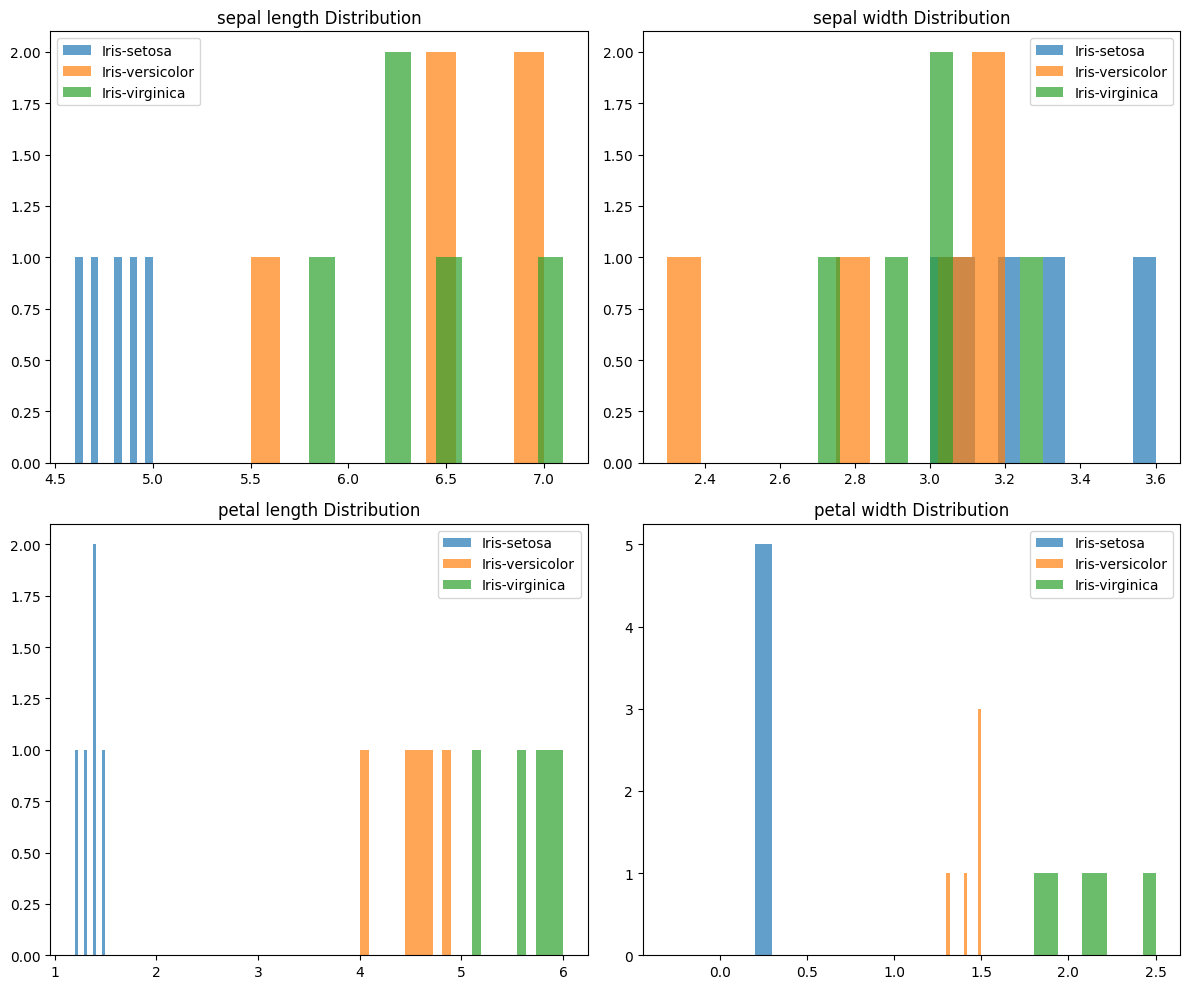

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi distribusi fitur per kelas
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
features = ['sepal length', 'sepal width', 'petal length', 'petal width']

for i, feature in enumerate(features):
    row, col = i//2, i%2
    for class_name in final_dataset['Class'].unique():
        class_data = final_dataset[final_dataset['Class'] == class_name]
        axes[row, col].hist(class_data[feature], alpha=0.7, label=class_name)
    axes[row, col].set_title(f'{feature} Distribution')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

## Data Preparation

### Load Dataset untuk Processing

In [162]:
df = pd.read_csv('decisiontree.csv')
df.head()

,id,Class,sepal length,sepal width,petal length,petal width
0,1,Iris-setosa,4.8,3.3,1.2,0.2
1,2,Iris-setosa,4.9,3.0,1.4,0.2
2,3,Iris-setosa,4.7,3.2,1.3,0.2
3,4,Iris-setosa,4.6,3.1,1.5,0.2
4,5,Iris-setosa,5.0,3.6,1.4,0.2


### Feature Engineering

In [163]:
# Feature Engineering: Buat area features
df['Sepal_Area'] = df['sepal length'] * df['sepal width']
df['Petal_Area'] = df['petal length'] * df['petal width']

# Lihat hasil feature engineering
print("Dataset dengan feature baru:")
df[['Class', 'sepal length', 'sepal width', 'Sepal_Area', 
    'petal length', 'petal width', 'Petal_Area']].head(15)

Dataset dengan feature baru:


,Class,sepal length,sepal width,Sepal_Area,petal length,petal width,Petal_Area
0,Iris-setosa,4.8,3.3,15.84,1.2,0.2,0.24
1,Iris-setosa,4.9,3.0,14.70,1.4,0.2,0.28
2,Iris-setosa,4.7,3.2,15.04,1.3,0.2,0.26
3,Iris-setosa,4.6,3.1,14.26,1.5,0.2,0.30
4,Iris-setosa,5.0,3.6,18.00,1.4,0.2,0.28
5,Iris-versicolor,7.0,3.2,22.40,4.7,1.4,6.58
6,Iris-versicolor,6.4,3.2,20.48,4.5,1.5,6.75
7,Iris-versicolor,6.9,3.1,21.39,4.9,1.5,7.35
8,Iris-versicolor,5.5,2.3,12.65,4.0,1.3,5.20
9,Iris-versicolor,6.5,2.8,18.20,4.6,1.5,6.90


In [164]:
area_only = df[['id', 'Sepal_Area', 'Petal_Area']]
area_only.to_json('area_features.json', orient='records', indent=4)

### Prepare Final Dataset

In [165]:
# Simpan target class terpisah (untuk evaluasi nanti)
target = df['Class'].copy()

# Buat dataset final dengan hanya 2 fitur area
features = df[['Sepal_Area', 'Petal_Area']].copy()

print("Target classes:")
print(target.value_counts())
print("\nFeatures untuk Decision Tree:")
print(features.head())
print(f"\nShape features: {features.shape}")

Target classes:
Class
Iris-setosa        5
Iris-versicolor    5
Iris-virginica     5
Name: count, dtype: int64

Features untuk Decision Tree:
   Sepal_Area  Petal_Area
0       15.84        0.24
1       14.70        0.28
2       15.04        0.26
3       14.26        0.30
4       18.00        0.28

Shape features: (15, 2)


### Data Summary

In [166]:
# Summary statistics untuk features
print("Summary Statistics:")
print(features.describe())

print("\nRange values per feature:")
print(f"Sepal_Area: {features['Sepal_Area'].min():.2f} - {features['Sepal_Area'].max():.2f}")
print(f"Petal_Area: {features['Petal_Area'].min():.2f} - {features['Petal_Area'].max():.2f}")

print("\nData quality check:")
print(f"Missing values: {features.isnull().sum().sum()}")
print(f"Total samples: {len(features)}")

Summary Statistics:
       Sepal_Area  Petal_Area
count   15.000000   15.000000
mean    17.898667    6.270667
std      3.050625    5.105436
min     12.650000    0.240000
25%     15.350000    0.290000
50%     18.200000    6.750000
75%     20.635000    9.885000
max     22.400000   15.000000

Range values per feature:
Sepal_Area: 12.65 - 22.40
Petal_Area: 0.24 - 15.00

Data quality check:
Missing values: 0
Total samples: 15


### Visualisasi Features vs Target

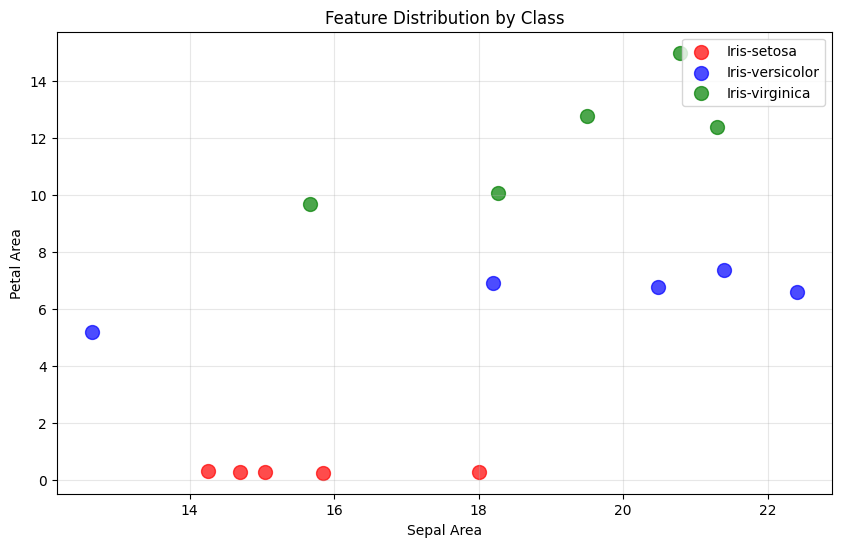

In [167]:
# Scatter plot untuk melihat separability
plt.figure(figsize=(10, 6))
colors = {'Iris-setosa': 'red', 'Iris-versicolor': 'blue', 'Iris-virginica': 'green'}

for class_name in target.unique():
    mask = target == class_name
    plt.scatter(features[mask]['Sepal_Area'], features[mask]['Petal_Area'], 
                c=colors[class_name], label=class_name, alpha=0.7, s=100)

plt.xlabel('Sepal Area')
plt.ylabel('Petal Area')
plt.title('Feature Distribution by Class')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Modeling

### Manual Decision Tree

In [168]:
import numpy as np
import pandas as pd
from collections import Counter
import math

# Function untuk menghitung entropy
def calculate_entropy(y):
    """
    Menghitung entropy dari sebuah array target
    """
    if len(y) == 0:
        return 0
    
    # Hitung proporsi setiap kelas
    proportions = np.bincount(y) / len(y)
    # Filter out zero proportions
    proportions = proportions[proportions > 0]
    
    # Hitung entropy
    entropy = -np.sum(proportions * np.log2(proportions))
    return entropy

# Test function
print("Testing entropy function:")
test_target = [0, 0, 1, 1, 1, 2]  # Mixed classes
print(f"Entropy of mixed classes: {calculate_entropy(test_target):.4f}")

Testing entropy function:
Entropy of mixed classes: 1.4591


#### Hitung Entropy Awal Dataset

In [169]:
# Convert target ke numeric untuk perhitungan
target_numeric = pd.Categorical(target).codes
class_mapping = {code: class_name for code, class_name in 
                enumerate(pd.Categorical(target).categories)}

print("Class mapping:")
for code, name in class_mapping.items():
    print(f"{code}: {name}")

# Hitung entropy awal
initial_entropy = calculate_entropy(target_numeric)
print(f"\nInitial Entropy: {initial_entropy:.4f}")

# Distribusi kelas
print(f"\nClass distribution:")
for code, name in class_mapping.items():
    count = np.sum(target_numeric == code)
    proportion = count / len(target_numeric)
    print(f"{name}: {count} samples ({proportion:.3f})")

Class mapping:
0: Iris-setosa
1: Iris-versicolor
2: Iris-virginica

Initial Entropy: 1.5850

Class distribution:
Iris-setosa: 5 samples (0.333)
Iris-versicolor: 5 samples (0.333)
Iris-virginica: 5 samples (0.333)


#### Function untuk Information Gain

In [170]:
def calculate_information_gain(X, y, feature_idx, threshold):
    """
    Menghitung information gain untuk split tertentu
    """
    # Split data berdasarkan threshold
    left_mask = X.iloc[:, feature_idx] <= threshold
    right_mask = ~left_mask
    
    # Jika salah satu split kosong, return 0
    if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
        return 0
    
    # Hitung entropy sebelum split
    parent_entropy = calculate_entropy(y)
    
    # Hitung entropy setelah split
    left_entropy = calculate_entropy(y[left_mask])
    right_entropy = calculate_entropy(y[right_mask])
    
    # Hitung weighted entropy
    n_left = np.sum(left_mask)
    n_right = np.sum(right_mask)
    n_total = len(y)
    
    weighted_entropy = (n_left/n_total) * left_entropy + (n_right/n_total) * right_entropy
    
    # Information gain
    info_gain = parent_entropy - weighted_entropy
    
    return info_gain

print("Information Gain function ready!")

Information Gain function ready!


#### Cari Best Split untuk Setiap Feature

In [171]:
def find_best_split(X, y):
    """
    Mencari split terbaik dari semua possible splits
    """
    best_gain = -1
    best_feature = None
    best_threshold = None
    best_split_info = {}
    
    for feature_idx in range(X.shape[1]):
        feature_name = X.columns[feature_idx]
        feature_values = X.iloc[:, feature_idx].unique()
        
        print(f"\nAnalyzing feature: {feature_name}")
        print(f"Unique values: {sorted(feature_values)}")
        
        # Test berbagai threshold (midpoint between consecutive values)
        thresholds = []
        sorted_values = sorted(feature_values)
        for i in range(len(sorted_values)-1):
            threshold = (sorted_values[i] + sorted_values[i+1]) / 2
            thresholds.append(threshold)
        
        feature_gains = []
        for threshold in thresholds:
            gain = calculate_information_gain(X, y, feature_idx, threshold)
            feature_gains.append((threshold, gain))
            print(f"  Threshold {threshold:.3f}: Info Gain = {gain:.4f}")
        
        # Find best threshold for this feature
        if feature_gains:
            best_threshold_feature = max(feature_gains, key=lambda x: x[1])
            if best_threshold_feature[1] > best_gain:
                best_gain = best_threshold_feature[1]
                best_feature = feature_idx
                best_threshold = best_threshold_feature[0]
                best_split_info = {
                    'feature_name': feature_name,
                    'feature_idx': feature_idx,
                    'threshold': best_threshold,
                    'info_gain': best_gain
                }
    
    return best_split_info

# Cari best split untuk root node
print("Finding best split for root node:")
print("="*50)
best_split = find_best_split(features, target_numeric)
print(f"\n🎯 BEST SPLIT:")
print(f"Feature: {best_split['feature_name']}")
print(f"Threshold: {best_split['threshold']:.3f}")
print(f"Information Gain: {best_split['info_gain']:.4f}")

Finding best split for root node:

Analyzing feature: Sepal_Area
Unique values: [np.float64(12.649999999999999), np.float64(14.26), np.float64(14.700000000000001), np.float64(15.040000000000001), np.float64(15.66), np.float64(15.839999999999998), np.float64(18.0), np.float64(18.2), np.float64(18.27), np.float64(19.5), np.float64(20.480000000000004), np.float64(20.79), np.float64(21.299999999999997), np.float64(21.39), np.float64(22.400000000000002)]
  Threshold 13.455: Info Gain = 0.1127
  Threshold 14.480: Info Gain = 0.0852
  Threshold 14.870: Info Gain = 0.1576
  Threshold 15.350: Info Gain = 0.2723
  Threshold 15.750: Info Gain = 0.1134
  Threshold 16.920: Info Gain = 0.2490
  Threshold 18.100: Info Gain = 0.5155
  Threshold 18.235: Info Gain = 0.4325
  Threshold 18.885: Info Gain = 0.3237
  Threshold 19.990: Info Gain = 0.2710
  Threshold 20.635: Info Gain = 0.1893
  Threshold 21.045: Info Gain = 0.1576
  Threshold 21.345: Info Gain = 0.2429
  Threshold 21.895: Info Gain = 0.1127


#### Review dan Validasi Split Pertama

In [172]:
# Ambil informasi best split
feature_name = best_split['feature_name']
threshold = best_split['threshold']
feature_idx = best_split['feature_idx']

print("🔍 DETAILED ANALYSIS OF BEST SPLIT")
print("="*60)
print(f"Split: {feature_name} <= {threshold:.3f}")

# Buat split berdasarkan threshold terbaik
left_mask = features.iloc[:, feature_idx] <= threshold
right_mask = ~left_mask

print(f"\nSplit Results:")
print(f"Left branch: {np.sum(left_mask)} samples")
print(f"Right branch: {np.sum(right_mask)} samples")

# Analisis distribusi kelas di setiap branch
print(f"\n📊 Class Distribution in Each Branch:")
print("-" * 40)

print("LEFT BRANCH (", f"{feature_name} <= {threshold:.3f}", "):")
left_classes = target_numeric[left_mask]
for code, name in class_mapping.items():
    count = np.sum(left_classes == code)
    if count > 0:
        print(f"  {name}: {count} samples")

print(f"\nRIGHT BRANCH (", f"{feature_name} > {threshold:.3f}", "):")
right_classes = target_numeric[right_mask]
for code, name in class_mapping.items():
    count = np.sum(right_classes == code)
    if count > 0:
        print(f"  {name}: {count} samples")

# Manual verification of information gain calculation
print(f"\n🧮 MANUAL CALCULATION VERIFICATION:")
print("-" * 40)
initial_entropy = calculate_entropy(target_numeric)
left_entropy = calculate_entropy(left_classes)
right_entropy = calculate_entropy(right_classes)

print(f"Initial entropy: {initial_entropy:.4f}")
print(f"Left entropy: {left_entropy:.4f}")
print(f"Right entropy: {right_entropy:.4f}")

# Weighted average entropy
n_left, n_right = len(left_classes), len(right_classes)
n_total = len(target_numeric)
weighted_entropy = (n_left/n_total) * left_entropy + (n_right/n_total) * right_entropy
info_gain = initial_entropy - weighted_entropy

print(f"Weighted entropy: {weighted_entropy:.4f}")
print(f"Information gain: {info_gain:.4f}")
print(f"Matches calculated: {abs(info_gain - best_split['info_gain']) < 0.0001}")

🔍 DETAILED ANALYSIS OF BEST SPLIT
Split: Petal_Area <= 2.750

Split Results:
Left branch: 5 samples
Right branch: 10 samples

📊 Class Distribution in Each Branch:
----------------------------------------
LEFT BRANCH ( Petal_Area <= 2.750 ):
  Iris-setosa: 5 samples

RIGHT BRANCH ( Petal_Area > 2.750 ):
  Iris-versicolor: 5 samples
  Iris-virginica: 5 samples

🧮 MANUAL CALCULATION VERIFICATION:
----------------------------------------
Initial entropy: 1.5850
Left entropy: -0.0000
Right entropy: 1.0000
Weighted entropy: 0.6667
Information gain: 0.9183
Matches calculated: True


#### Visualisasi Split Pertama

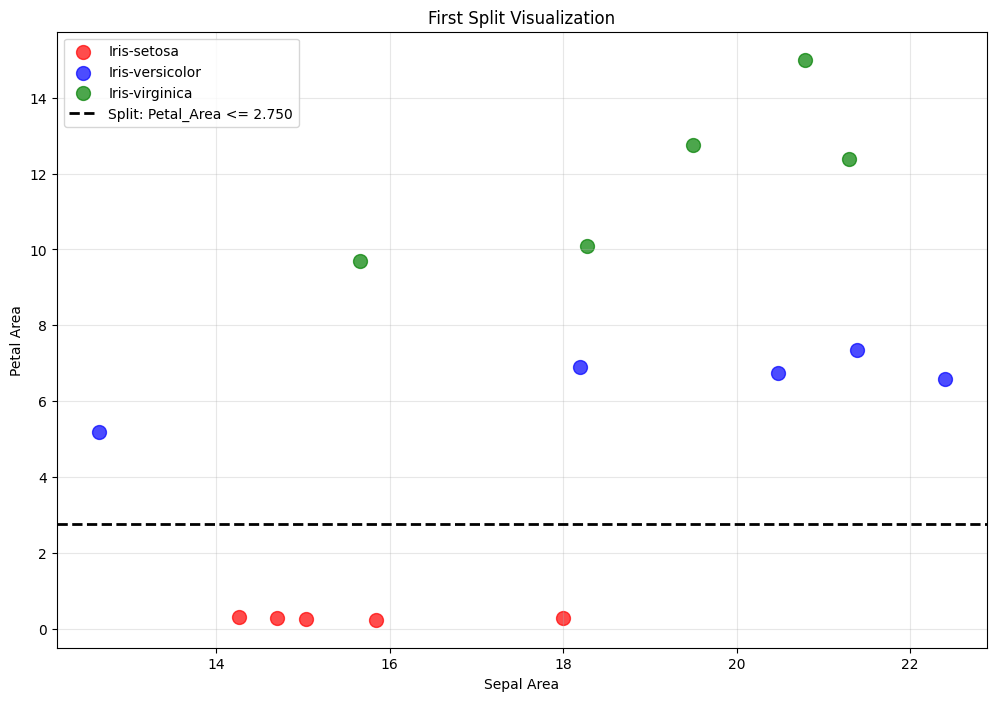

🔍 DATA POINTS IN EACH BRANCH:

LEFT BRANCH:
   Sepal_Area  Petal_Area        Class
0       15.84        0.24  Iris-setosa
1       14.70        0.28  Iris-setosa
2       15.04        0.26  Iris-setosa
3       14.26        0.30  Iris-setosa
4       18.00        0.28  Iris-setosa

RIGHT BRANCH:
    Sepal_Area  Petal_Area            Class
5        22.40        6.58  Iris-versicolor
6        20.48        6.75  Iris-versicolor
7        21.39        7.35  Iris-versicolor
8        12.65        5.20  Iris-versicolor
9        18.20        6.90  Iris-versicolor
10       20.79       15.00   Iris-virginica
11       15.66        9.69   Iris-virginica
12       21.30       12.39   Iris-virginica
13       18.27       10.08   Iris-virginica
14       19.50       12.76   Iris-virginica


In [173]:
# Visualisasi hasil split
plt.figure(figsize=(12, 8))

# Plot data points dengan warna berdasarkan kelas
colors = {'Iris-setosa': 'red', 'Iris-versicolor': 'blue', 'Iris-virginica': 'green'}
for class_name in target.unique():
    mask = target == class_name
    plt.scatter(features[mask]['Sepal_Area'], features[mask]['Petal_Area'], 
                c=colors[class_name], label=class_name, alpha=0.7, s=100)

# Tambahkan garis split
if feature_name == 'Sepal_Area':
    plt.axvline(x=threshold, color='black', linestyle='--', linewidth=2, 
                label=f'Split: {feature_name} <= {threshold:.3f}')
else:  # Petal_Area
    plt.axhline(y=threshold, color='black', linestyle='--', linewidth=2, 
                label=f'Split: {feature_name} <= {threshold:.3f}')

plt.xlabel('Sepal Area')
plt.ylabel('Petal Area')
plt.title('First Split Visualization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Tampilkan data points yang masuk ke setiap branch
print("🔍 DATA POINTS IN EACH BRANCH:")
print("\nLEFT BRANCH:")
left_data = features[left_mask].copy()
left_data['Class'] = target[left_mask]
print(left_data)

print("\nRIGHT BRANCH:")
right_data = features[right_mask].copy()
right_data['Class'] = target[right_mask]
print(right_data)

#### Recursive Tree Building Class

In [174]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
import seaborn as sns

class EnhancedDecisionTree:
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.class_mapping = None
        
    def fit(self, X, y, feature_names=None):
        """Build decision tree recursively"""
        self.feature_names = feature_names if feature_names else [f'feature_{i}' for i in range(X.shape[1])]
        
        # Convert y to numeric if needed
        if hasattr(y, 'dtype') and y.dtype == 'object':
            y_numeric = pd.Categorical(y).codes
            self.class_mapping = {code: class_name for code, class_name in 
                                enumerate(pd.Categorical(y).categories)}
        else:
            y_numeric = y
            
        self.tree = self._build_tree(X, y_numeric, depth=0)
        return self
    
    def _build_tree(self, X, y, depth):
        """Recursive function to build tree"""
        node_info = {
            'samples': len(y),
            'depth': depth,
            'class_counts': {self.class_mapping[i]: np.sum(y == i) for i in np.unique(y)},
            'majority_class': self.class_mapping[np.bincount(y).argmax()],
            'entropy': calculate_entropy(y)
        }
        
        # Stopping criteria
        if (depth >= self.max_depth or 
            len(y) < self.min_samples_split or 
            len(np.unique(y)) == 1):
            
            node_info['is_leaf'] = True
            node_info['prediction'] = self.class_mapping[np.bincount(y).argmax()]
            return node_info
        
        # Find best split
        best_split = self._find_best_split(X, y)
        
        if best_split is None or best_split['info_gain'] <= 0:
            node_info['is_leaf'] = True
            node_info['prediction'] = self.class_mapping[np.bincount(y).argmax()]
            return node_info
        
        # Create internal node
        node_info['is_leaf'] = False
        node_info['feature_idx'] = best_split['feature_idx']
        node_info['feature_name'] = best_split['feature_name']
        node_info['threshold'] = best_split['threshold']
        node_info['info_gain'] = best_split['info_gain']
        
        # Split data
        left_mask = X.iloc[:, best_split['feature_idx']] <= best_split['threshold']
        right_mask = ~left_mask
        
        # Recursive calls
        node_info['left'] = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        node_info['right'] = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return node_info
    
    def _find_best_split(self, X, y):
        """Find best split for current node"""
        best_gain = -1
        best_split = None
        
        for feature_idx in range(X.shape[1]):
            feature_values = X.iloc[:, feature_idx].unique()
            sorted_values = sorted(feature_values)
            
            for i in range(len(sorted_values)-1):
                threshold = (sorted_values[i] + sorted_values[i+1]) / 2
                gain = calculate_information_gain(X, y, feature_idx, threshold)
                
                if gain > best_gain:
                    best_gain = gain
                    best_split = {
                        'feature_idx': feature_idx,
                        'feature_name': self.feature_names[feature_idx],
                        'threshold': threshold,
                        'info_gain': gain
                    }
        
        return best_split
    
    def predict(self, X):
        """Make predictions using the built tree"""
        predictions = []
        for idx in range(len(X)):
            sample = X.iloc[idx]  # FIX: Use iloc instead of direct indexing
            prediction = self._predict_single(sample, self.tree)
            predictions.append(prediction)
        return predictions
    
    def _predict_single(self, sample, node):
        """Predict single sample"""
        if node['is_leaf']:
            return node['prediction']
        
        # FIX: Use feature name instead of index
        if sample[node['feature_name']] <= node['threshold']:
            return self._predict_single(sample, node['left'])
        else:
            return self._predict_single(sample, node['right'])

print("✅ Enhanced Decision Tree class ready!")

✅ Enhanced Decision Tree class ready!


#### Build Tree

🌳 Building Enhanced Decision Tree...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5992\1178053272.py:130: UserWarning: Glyph 128256 (\N{TWISTED RIGHTWARDS ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5992\1178053272.py:130: UserWarning: Glyph 127811 (\N{LEAF FLUTTERING IN WIND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\GitHub\lecture-projects\Data-Mining\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128256 (\N{TWISTED RIGHTWARDS ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\GitHub\lecture-projects\Data-Mining\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127811 (\N{LEAF FLUTTERING IN WIND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


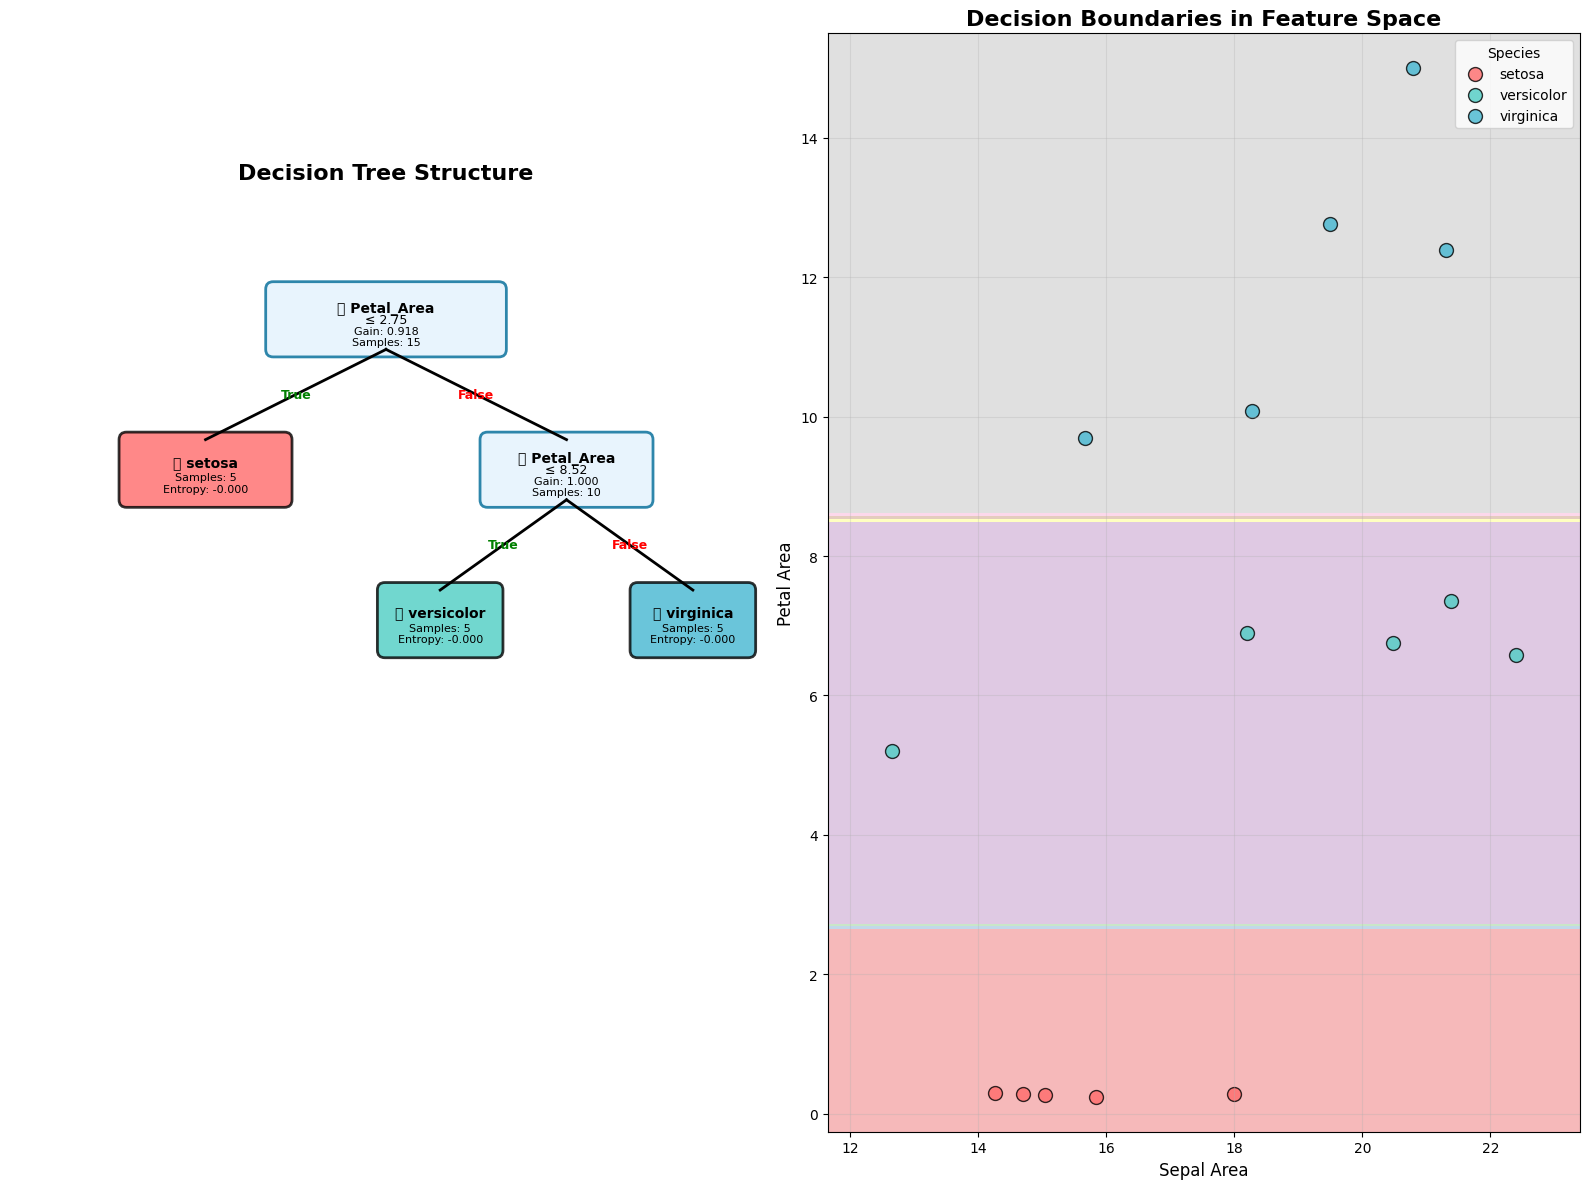

In [175]:
def visualize_decision_tree(tree_model, features, target, figsize=(16, 12)):
    """
    Create professional decision tree visualization
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Left plot: Tree structure
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)
    ax1.set_aspect('equal')
    ax1.axis('off')
    ax1.set_title('Decision Tree Structure', fontsize=16, fontweight='bold', pad=20)
    
    # Colors for classes
    class_colors = {
        'Iris-setosa': '#FF6B6B',
        'Iris-versicolor': '#4ECDC4', 
        'Iris-virginica': '#45B7D1'
    }
    
    def draw_node(node, x, y, width, ax, level=0):
        """Draw a single node"""
        if node['is_leaf']:
            # Leaf node
            color = class_colors.get(node['prediction'], '#95E1D3')
            
            # Create fancy box for leaf
            box = FancyBboxPatch(
                (x-width/2, y-0.4), width, 0.8,
                boxstyle="round,pad=0.1",
                facecolor=color,
                edgecolor='black',
                linewidth=2,
                alpha=0.8
            )
            ax.add_patch(box)
            
            # Add text
            ax.text(x, y+0.1, f'🍃 {node["prediction"].split("-")[1]}', 
                   ha='center', va='center', fontweight='bold', fontsize=10)
            ax.text(x, y-0.1, f'Samples: {node["samples"]}', 
                   ha='center', va='center', fontsize=8)
            ax.text(x, y-0.25, f'Entropy: {node["entropy"]:.3f}', 
                   ha='center', va='center', fontsize=8)
            
        else:
            # Internal node
            box = FancyBboxPatch(
                (x-width/2, y-0.4), width, 0.8,
                boxstyle="round,pad=0.1",
                facecolor='#E8F4FD',
                edgecolor='#2E86AB',
                linewidth=2
            )
            ax.add_patch(box)
            
            # Add text
            ax.text(x, y+0.15, f'🔀 {node["feature_name"]}', 
                   ha='center', va='center', fontweight='bold', fontsize=10)
            ax.text(x, y, f'≤ {node["threshold"]:.2f}', 
                   ha='center', va='center', fontsize=9)
            ax.text(x, y-0.15, f'Gain: {node["info_gain"]:.3f}', 
                   ha='center', va='center', fontsize=8)
            ax.text(x, y-0.3, f'Samples: {node["samples"]}', 
                   ha='center', va='center', fontsize=8)
            
            # Draw children
            child_width = width * 0.7
            child_y = y - 2
            left_x = x - width*0.8
            right_x = x + width*0.8
            
            # Draw connections
            ax.plot([x, left_x], [y-0.4, child_y+0.4], 'k-', linewidth=2)
            ax.plot([x, right_x], [y-0.4, child_y+0.4], 'k-', linewidth=2)
            
            # Add labels on connections
            ax.text(x-width*0.4, y-1, 'True', ha='center', va='center', 
                   fontsize=9, fontweight='bold', color='green')
            ax.text(x+width*0.4, y-1, 'False', ha='center', va='center', 
                   fontsize=9, fontweight='bold', color='red')
            
            # Recursive calls
            draw_node(node['left'], left_x, child_y, child_width, ax, level+1)
            draw_node(node['right'], right_x, child_y, child_width, ax, level+1)
    
    # Draw the tree
    draw_node(tree_model.tree, 5, 8.5, 3, ax1)
    
    # Right plot: Feature space with decision boundaries
    ax2.set_title('Decision Boundaries in Feature Space', fontsize=16, fontweight='bold')
    
    # Create mesh for decision boundaries
    x_min, x_max = features['Sepal_Area'].min() - 1, features['Sepal_Area'].max() + 1
    y_min, y_max = features['Petal_Area'].min() - 0.5, features['Petal_Area'].max() + 0.5
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Create prediction mesh
    mesh_points = pd.DataFrame({
        'Sepal_Area': xx.ravel(),
        'Petal_Area': yy.ravel()
    })
    
    mesh_predictions = tree_model.predict(mesh_points)
    mesh_predictions = [pred.split('-')[1] for pred in mesh_predictions]  # Shorten names
    
    # Create color map
    color_map = {'setosa': 0, 'versicolor': 1, 'virginica': 2}
    Z = np.array([color_map[pred] for pred in mesh_predictions])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundaries
    ax2.contourf(xx, yy, Z, alpha=0.3, cmap='Set1')
    
    # Plot data points
    for class_name in target.unique():
        mask = target == class_name
        short_name = class_name.split('-')[1]
        color = class_colors[class_name]
        ax2.scatter(features[mask]['Sepal_Area'], features[mask]['Petal_Area'], 
                   c=color, label=short_name, alpha=0.8, s=100, edgecolors='black')
    
    ax2.set_xlabel('Sepal Area', fontsize=12)
    ax2.set_ylabel('Petal Area', fontsize=12)
    ax2.legend(title='Species', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Build and visualize tree
tree_model = EnhancedDecisionTree(max_depth=3, min_samples_split=2)
tree_model.fit(features, target, feature_names=features.columns.tolist())

print("🌳 Building Enhanced Decision Tree...")
visualize_decision_tree(tree_model, features, target)

#### Test Tree dengan Data Training

🎯 DETAILED PREDICTION RESULTS
 Index  Sepal_Area  Petal_Area          Actual       Predicted Correct
     0       15.84        0.24     Iris-setosa     Iris-setosa       ✅
     1       14.70        0.28     Iris-setosa     Iris-setosa       ✅
     2       15.04        0.26     Iris-setosa     Iris-setosa       ✅
     3       14.26        0.30     Iris-setosa     Iris-setosa       ✅
     4       18.00        0.28     Iris-setosa     Iris-setosa       ✅
     5       22.40        6.58 Iris-versicolor Iris-versicolor       ✅
     6       20.48        6.75 Iris-versicolor Iris-versicolor       ✅
     7       21.39        7.35 Iris-versicolor Iris-versicolor       ✅
     8       12.65        5.20 Iris-versicolor Iris-versicolor       ✅
     9       18.20        6.90 Iris-versicolor Iris-versicolor       ✅
    10       20.79       15.00  Iris-virginica  Iris-virginica       ✅
    11       15.66        9.69  Iris-virginica  Iris-virginica       ✅
    12       21.30       12.39  Iris-virginica 

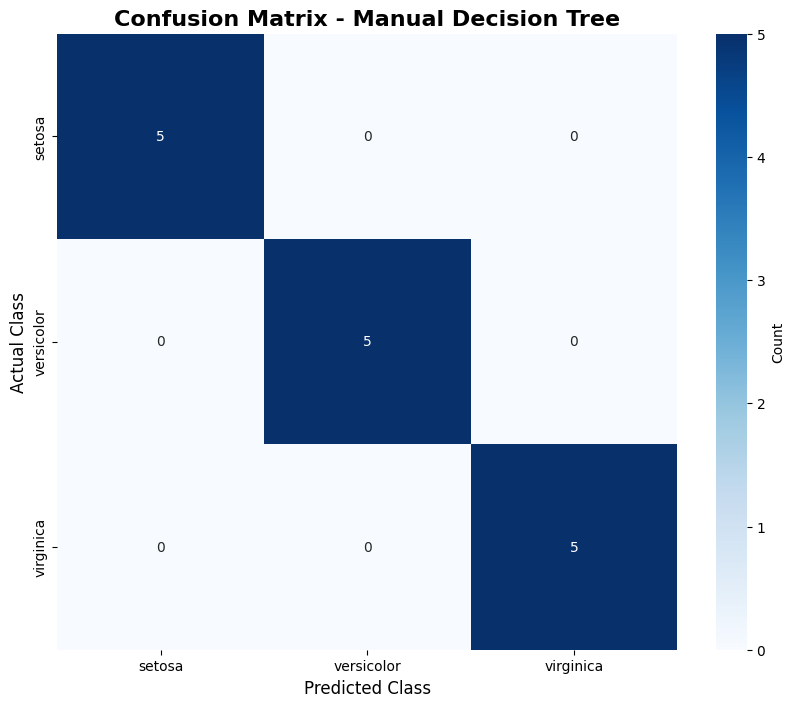


🌳 TREE STATISTICS
Total Nodes: 5
Leaf Nodes: 3
Internal Nodes: 2
Tree Depth: 2


In [176]:
# Test dengan data training
predictions = tree_model.predict(features)

# Create comprehensive results DataFrame
results_df = pd.DataFrame({
    'Index': range(len(features)),
    'Sepal_Area': features['Sepal_Area'].round(2),
    'Petal_Area': features['Petal_Area'].round(2),
    'Actual': target,
    'Predicted': predictions,
    'Correct': ['✅' if actual == pred else '❌' for actual, pred in zip(target, predictions)]
})

print("🎯 DETAILED PREDICTION RESULTS")
print("=" * 80)
print(results_df.to_string(index=False))

# Enhanced accuracy metrics
accuracy = np.mean(predictions == target)
print(f"\n📊 PERFORMANCE METRICS")
print("=" * 40)
print(f"Training Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")

# Per-class accuracy
print(f"\nPer-Class Performance:")
for class_name in sorted(target.unique()):
    class_mask = target == class_name
    class_predictions = [predictions[i] for i in range(len(predictions)) if class_mask.iloc[i]]
    class_actual = target[class_mask]
    class_accuracy = np.mean(class_predictions == class_actual)
    print(f"  {class_name}: {class_accuracy:.3f} ({class_accuracy*100:.1f}%)")

# Beautiful confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(target, predictions)
class_names = sorted(target.unique())
class_names_short = [name.split('-')[1] for name in class_names]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names_short, yticklabels=class_names_short,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Manual Decision Tree', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class', fontsize=12)
plt.show()

# Tree statistics
def get_tree_stats(node):
    """Get tree statistics"""
    if node['is_leaf']:
        return {'nodes': 1, 'leaves': 1, 'max_depth': 0}
    
    left_stats = get_tree_stats(node['left'])
    right_stats = get_tree_stats(node['right'])
    
    return {
        'nodes': 1 + left_stats['nodes'] + right_stats['nodes'],
        'leaves': left_stats['leaves'] + right_stats['leaves'],
        'max_depth': 1 + max(left_stats['max_depth'], right_stats['max_depth'])
    }

stats = get_tree_stats(tree_model.tree)
print(f"\n🌳 TREE STATISTICS")
print("=" * 30)
print(f"Total Nodes: {stats['nodes']}")
print(f"Leaf Nodes: {stats['leaves']}")
print(f"Internal Nodes: {stats['nodes'] - stats['leaves']}")
print(f"Tree Depth: {stats['max_depth']}")

## Evaluation

## Deployment